# Finding the Centers of the Ellipses

We include all the required libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

## Image Loading

Text(0, 0.5, 'Frequency')

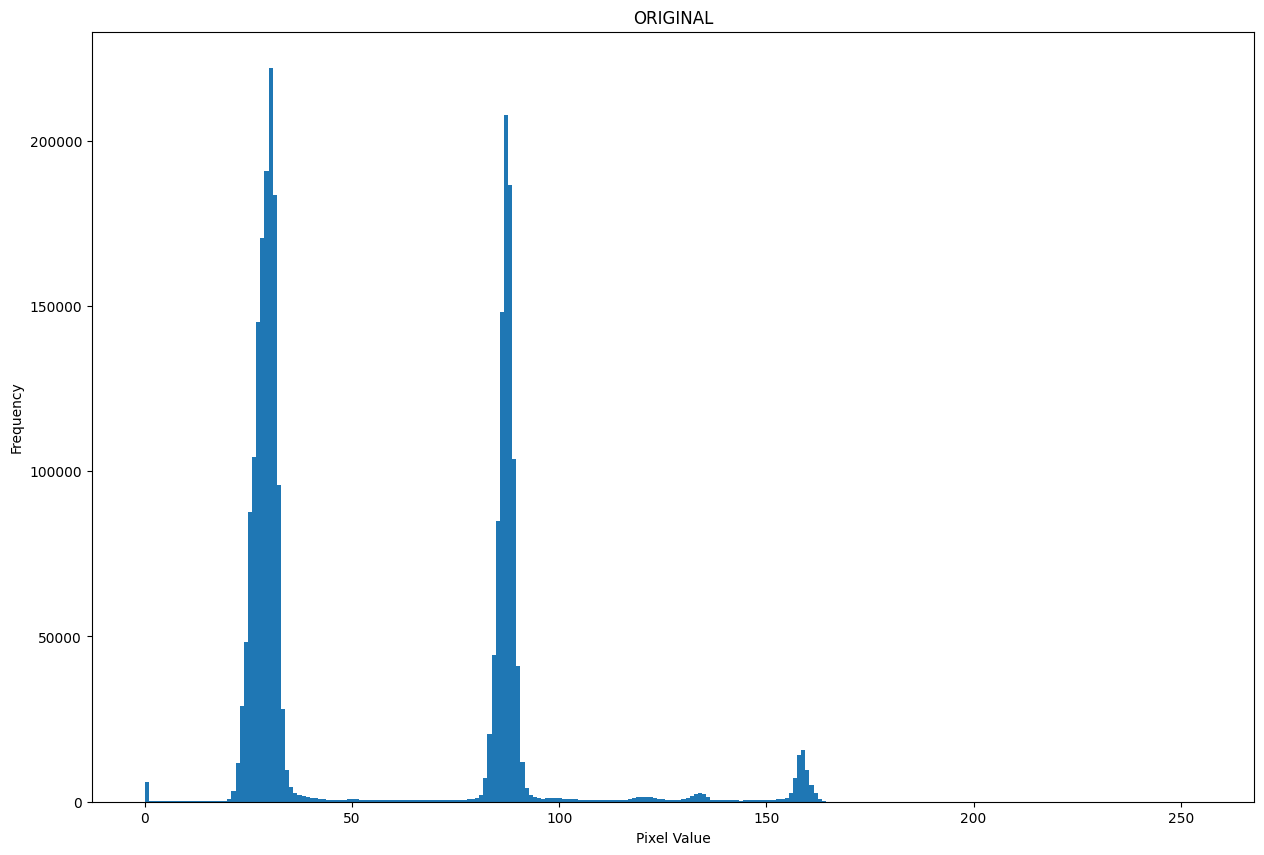

In [56]:
# We get the path to the current script
baseFolder = os.getcwd()

# Folder for the 25 mm lens photos
#folder = os.path.join(baseFolder, "FINAL_PHOTOS", "ALIGN_DEFFECT_25_MM")
# Folder for the 12 mm lens photos
folder = os.path.join(baseFolder, "FINAL_PHOTOS", "ALIGN_DEFFECT_12_MM")

# We load the image
img = cv.imread(os.path.join(folder, "12.png"), 0)
logo = cv.imread(os.path.join(folder, "logo.png"), 0)

# We load the camera calibration results (We took the photos with the first camera setup)
#cameraParameters = np.load(baseFolder + "/calibration/camera_lens_25mm.npz")
cameraParameters = np.load(baseFolder + "/calibration/camera_lens_12mm.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']
res = cameraParameters['res']

# We find the dimensions of the image
h, w = img.shape[:2]

# We find the new camera matrix and interested region
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# We undistort the image
udst_img = cv.undistort(img, mtx, dist, None, newcameramtx)

# We show the histogram of the image
plt.figure(figsize=(15, 10))
plt.hist(udst_img.ravel(), bins=256, range=(0, 255))
plt.title("ORIGINAL")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

(np.float64(-0.5), np.float64(188.5), np.float64(141.5), np.float64(-0.5))

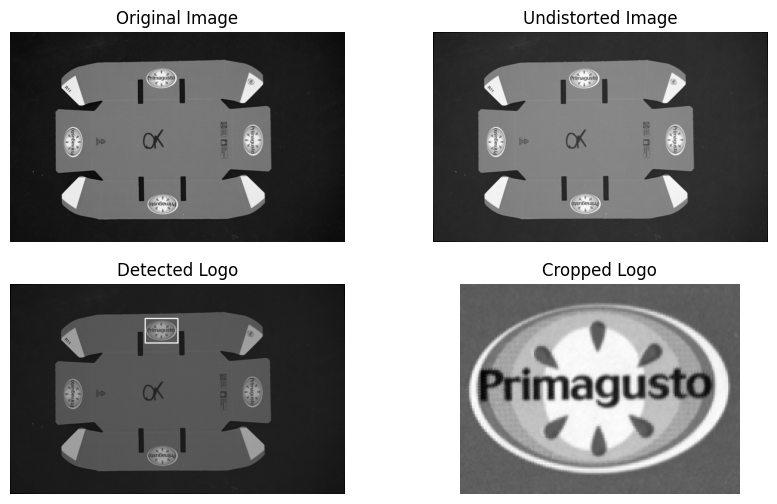

In [57]:
def logoDetection(image, template):
    """
    Detects and extracts a logo region from a grayscale image using template matching.

    This function uses the provided template image (representing a logo) to locate its 
    position within the input image using normalized cross-correlation. It draws a 
    rectangle around the detected region and returns the cropped area, the match confidence,
    and a visualization of the detection.

    Parameters
    ----------
    image : np.ndarray
        Input grayscale image where the logo will be detected.

    template : np.ndarray
        Template image (logo) used for matching. Must be smaller than or equal to the input image.

    Returns
    -------
    cropped_logo : np.ndarray
        Cropped region of the original image containing the detected logo.

    max_val : float
        Matching confidence value (between 0 and 1) indicating how strong the match is.

    img2 : np.ndarray
        A copy of the input image with a rectangle drawn around the detected logo.
    """

    # We employ a template image taken from the original images taken by the camera
    # this is required to detect in a easy way the logo in the images
    h, w = template.shape

    # We are going to use the CCOR_NORMED method to detect the logo in the image
    img2 = image.copy()
    result = cv.matchTemplate(img2, template, cv.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

    # We define the location of the logo in the image
    # We only need to define the bottom right corner of the rectangle
    bottom_right = (max_loc[0] + w, max_loc[1] + h)

    # We draw a rectangle around the logo in the image
    cv.rectangle(img2, max_loc, bottom_right, [255,0,0], 5)

    cropped_logo = image[max_loc[1]:bottom_right[1], max_loc[0]:bottom_right[0]]

    return cropped_logo, max_val, img2

logo_img, max_val_detection, img_2 = logoDetection(udst_img, logo)

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(udst_img, cmap='gray')
plt.title("Undistorted Image")
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(img_2, cmap='gray')
plt.title("Detected Logo")
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(logo_img, cmap='gray')
plt.title('Cropped Logo')
plt.axis("off")


## Initial preprocessing

We start by doing a little of preprocessing, we undistort the image, and moreover we create an histogram graph for the image

In [58]:
def stats_image(image):
    """
    Computes key statistical metrics of a grayscale image and determines two intensity thresholds.

    This function flattens the image into a 1D array of pixel intensities and calculates 
    descriptive statistics including quartiles, mean, standard deviation, minimum, and maximum values.
    Based on these values, it computes two thresholds that can be used for further image processing 
    such as edge detection, thresholding, or contrast adjustment.

    Parameters
    ----------
    image : np.ndarray
        Input grayscale image as a 2D NumPy array.

    Returns
    -------
    th1 : float
        First threshold value, calculated as Q1 - 20. This can serve as a lower limit for 
        intensity-based filtering.

    th2 : float
        Second threshold value, adjusted based on the image contrast. If the image has high 
        contrast (i.e., max - Q3 > 2 * IQR), this threshold is raised. Otherwise, it is set 
        slightly below Q3.
    """
    
    # We start by transforming the image to a 1D array
    pixels = image.flatten()

    # We calculate the statistical values of the image
    q1 = np.percentile(pixels, 25)
    q2 = np.median(pixels)
    q3 = np.percentile(pixels, 75)
    mean = np.mean(pixels)
    std_dev = np.std(pixels)
    min_val = np.min(pixels)
    max_val = np.max(pixels)

    # The First threshold was tested to have a value of 20 below Q1
    # th1 = q1 - 20
    th1 = q1

    # The value of the second threshold is determined by the contrast of the image
    if (max_val - q3) > 30:
        th2 = 100#min(q3 + 50, max_val - 20)
        print("The image has a high level of contrast.")
    else:
        th2 = q3 + 20
        print("The image has a low level of contrast.")


    print(f"Q1: {q1}, Mediana (Q2): {q2}, Q3: {q3}")
    print(f"Mean: {mean}, Standar Deviation: {std_dev}")
    print(f"Minimum: {min_val}, Maximum: {max_val}")      
    return th1, th2

th1, th2 = stats_image(udst_img)

print(f"Threshold 1: {th1}, Threshold 2: {th2}")

The image has a high level of contrast.
Q1: 28.0, Mediana (Q2): 31.0, Q3: 87.0
Mean: 55.61717305757938, Standar Deviation: 34.14365660048734
Minimum: 0, Maximum: 167
Threshold 1: 28.0, Threshold 2: 100


## Finding Ellipses

In [59]:
def ellipseMask (image, ellipse, white):
    # Ellipse mask for saving the logo
    mask_filled = np.zeros_like(image)
    cv.ellipse(mask_filled, ellipse, 255, thickness=cv.FILLED)

    # Mask for the border
    mask_border = np.zeros_like(image)
    cv.ellipse(mask_border, ellipse, 255, thickness=1)

    # We apply the masks to the image
    masked_image = image.copy()

    if white:
        # We put the border in white and the contour
        masked_image[mask_border == 255] = 255
        masked_image[mask_filled == 0] = 255
    else:
        # We put the border in black and the contour
        masked_image[mask_border == 255] = 0
        masked_image[mask_filled == 0] = 0
    
    return masked_image



def formCenter(image):
    """
    Detects and returns the center points of an elliptical shape within a grayscale image.
    
    This function identifies the ellipse corresponding to a logo or form in the image and 
    computes its center based on both the original and a binarized version of the image. 
    It returns a visualization with ellipses and centers marked in different colors.

    Parameters
    ----------
    image : np.ndarray
        Input grayscale image in which the elliptical form is to be detected.

    Returns
    -------
    img_Result : np.ndarray
        Color image with the detected ellipses and their centers drawn.
        - Green: Ellipse and center from the original image.
        - Blue: Ellipse and center from the binarized masked image.
    whiteCenter : tuple
        Coordinates (x, y) of the center of the ellipse detected in the blurred image.
    colorCenter : tuple
        Coordinates (x, y) of the center of the ellipse detected in the thresholded image.
    """

    # We start by detecting the edges in the image for this purpose we use the canny method
    blur = cv.GaussianBlur(image, (11 , 11), 1)

    # We find the center of the ellipse in the closed image
    whiteCenter, max_contour1, whiteEllipse, whiteLengths = findEllipseCenter(blur)

    masked_image = ellipseMask(image, whiteEllipse, True)

    #plt.figure(figsize=(15,10))
    #plt.imshow(masked_image, cmap='gray')
    #plt.title("Image with Masked Logo")
    #plt.axis('off')

    # We threshold the masked image to create a binary image
    _, thBinary = cv.threshold(masked_image, th2, 255, cv.THRESH_BINARY)

    #plt.figure(figsize=(15,10))
    #plt.imshow(thBinary, cmap='gray')
    #plt.title("Binary Image after Thresholding")
    #plt.axis('off')

    # We find the center of the ellipse in the binary image
    colorCenter, max_contour2, colorEllipse, colorLengths = findEllipseCenter(thBinary)

    img_Result = image.copy()
    # We make this a color image
    img_Result = cv.cvtColor(img_Result, cv.COLOR_GRAY2BGR)
    # We draw the white ellipse contour and center in green
    cv.ellipse(img_Result, whiteEllipse, (0, 255, 0), 2)
    cv.circle(img_Result, whiteCenter, 1, (0, 255, 0),  -1)
    # We draw the color ellipse contour and center in Blue
    cv.ellipse(img_Result, colorEllipse, (255, 0, 0), 2)
    cv.circle(img_Result, colorCenter, 1, (255, 0, 0), -1)

    return whiteCenter, colorCenter, whiteEllipse, colorEllipse, whiteLengths, colorLengths, img_Result


def findEllipseCenter(image):
    """
    Detects the largest closed contour in an image and fits an ellipse to it, returning its center.

    This function processes a grayscale image to detect edges using the Canny method, 
    connects nearby edges using morphological closing with an elliptical kernel, 
    and then finds the largest external contour. An ellipse is fitted to that contour, 
    and the center of the ellipse is returned along with the contour and ellipse parameters.

    Parameters
    ----------
    image : np.ndarray
        Grayscale input image.

    Returns
    -------
    center : tuple
        Coordinates (x, y) of the center of the fitted ellipse.
    
    max_contour : np.ndarray
        The contour (as a NumPy array of points) to which the ellipse was fitted.
    
    ellipse : tuple
        Parameters of the fitted ellipse in the format ((x_center, y_center), (major_axis, minor_axis), angle),
        as returned by `cv2.fitEllipse()`.
    """

    # We apply the canny edge detection to the image
    edges = cv.Canny(image, 10, 20, L2gradient=True)

    #plt.figure(figsize=(15,10))
    #plt.imshow(edges, cmap='gray')
    #plt.title("Edges Detected")
    #plt.axis('off')
    #plt.show()

    # We close the edges, by creating an elliptical kernel that we will use to close the edges
    # This will connect the edges that are close to each other
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
    closed = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)

    # We start by finding the contours in the image
    contours, _ = cv.findContours(closed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Then, we are going to select the largest contour in terms of area
    max_contour = max(contours, key=cv.contourArea)

    # We are going to fit an ellipse to the largest contour
    ellipse = cv.fitEllipse(max_contour)

    # we get the center of the ellipse
    center = (int(ellipse[0][0]), int(ellipse[0][1]))

    # We get the ellipse lengths
    axes_lengths = (int(ellipse[1][0]), int(ellipse[1][1]))

    return center, max_contour, ellipse, axes_lengths

def textCenter(image):
    """
    Detects the bounding box and center of the main text region in a grayscale image.

    This function processes a grayscale image to isolate areas containing text. 
    It detects the external contours of these regions, filters them based on perimeter, 
    and computes the center of the smallest rectangle that bounds all valid text contours.
    It returns the center and a visualization image with contours and bounding box.

    Parameters
    ----------
    img : np.ndarray
        Input grayscale image containing textual elements.

    Returns
    -------
    center : tuple
        Coordinates (x, y) representing the center of the bounding rectangle around the text.
    
    contour_vis : np.ndarray
        Color image (BGR) of the original binary image with:
        - Green contours around detected text regions.
        - A blue rectangle around the full text area.
        - A blue circle marking the center of the bounding rectangle.
    """
    

    # We start by thresholding the image to keep only the text
    _, thBinary = cv.threshold(image, 75, 255, cv.THRESH_BINARY)

    # We detect the edges using Canny
    low_thresh  = 50
    high_thresh = 150
    edges_masked = cv.Canny(thBinary, low_thresh, high_thresh, apertureSize=3)

    # We create a mask to keep only the text area
    contours_masked, _ = cv.findContours(edges_masked, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # We crete a copy of the binary image to draw the contours
    contour_vis = cv.cvtColor(thBinary, cv.COLOR_GRAY2BGR)

    # Minimum perimeter to consider a contour
    minimum_Perimeter = 50  # This value can be adjusted!

    rect_x_izq = 10000
    rect_x_der = 0
    rect_y_up = 10000
    rect_y_down = 0

    # We only consider contours with a perimeter larger than the minimum, to rull out noise
    for contour in contours_masked:
        perimeter = cv.arcLength(contour, True)
        if perimeter > minimum_Perimeter:

            # We extract the coordinates
            points = contour[:, 0, :]

            cv.drawContours(contour_vis, [contour], -1, (0, 255, 0), 2)

            # Extreme coordinates of the contour
            x_left = points[:, 0].min()
            x_rigth = points[:, 0].max()
            y_up = points[:, 1].min()
            y_down = points[:, 1].max()

            # We update the rectangle coordinates that bounds the text
            rect_x_izq = min(rect_x_izq, x_left)
            rect_x_der = max(rect_x_der, x_rigth)
            rect_y_up = min(rect_y_up, y_up)
            rect_y_down = max(rect_y_down, y_down)

    # We find the center of the rectangle that bounds the text
    center = ((rect_x_izq + rect_x_der) // 2, (rect_y_up + rect_y_down) // 2)

    # We draw the rectangle and the circle in the image
    cv.rectangle(contour_vis, (rect_x_izq, rect_y_up), (rect_x_der, rect_y_down), (0, 0, 255), 2)
    cv.circle(contour_vis, center, 2, (0, 0, 255), -1)

    return center, contour_vis

def find_word_center(image: np.ndarray, ellipse):
    """
    Detecta el centro de la palabra "Primagusto" en la imagen tratándola como una forma.

    Args:
        image: La imagen de entrada en escala de grises.

    Returns:
        Una tupla (x, y) con las coordenadas del centro, o None si no se detecta.
    """

    masked = ellipseMask(image, ellipse, True)
    # 1. Umbralización (Thresholding)
    # Convertimos la imagen a binaria. Como el texto es oscuro sobre fondo claro,
    # usamos THRESH_BINARY_INV para que el texto se vuelva blanco y el fondo negro.
    # El valor de 130 es un buen punto de partida, se puede ajustar.
    _, thresh = cv.threshold(masked, 65, 255, cv.THRESH_BINARY_INV)

    # 2. Operaciones Morfológicas para conectar las letras
    # Creamos un kernel rectangular que es mucho más ancho que alto. Esto conectará
    # las letras horizontalmente sin fusionar la palabra con los anillos del logo.
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (25, 5))
    
    # Aplicamos una 'Clausura' para rellenar los huecos entre las letras.
    closed = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)

    # 3. Detección de Contornos
    # Encontramos los contornos en la imagen morfológicamente cerrada.
    # RETR_EXTERNAL es eficiente ya que solo busca los contornos exteriores.
    contours, _ = cv.findContours(closed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No se encontraron contornos.")
        return None

    # 4. Seleccionar el contorno correcto y calcular su centro
    # Suponemos que la palabra unificada es el contorno con el área más grande.
    word_contour = max(contours, key=cv.contourArea)

    # Calculamos los momentos de imagen del contorno.
    M = cv.moments(word_contour)

    # A partir de los momentos, calculamos el centroide (x, y).
    # Se añade una comprobación para evitar la división por cero.
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        center = (cX, cY)
        img = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        #cv.drawContours(img, [word_contour], -1, (0, 255, 0), 1)
        cv.drawContours(img, contours, -1, (0, 255, 0), 1)
        cv.circle(img, center, 2, (255, 0, 0), -1)
        return center, img
    else:
        print("No se pudo calcular el centroide.")
        return None


# Logos detection

In [60]:
def focus_area(image):
    # Thresholding the imnage OTSU gives us the optimal threshold value
    _ , th_Bin_OTSU = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # Find the contours in the image
    contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # We search the biggest contour Area Based
    contour_max = max(contours, key=cv.contourArea)

    # Bounding box of the biggest contour
    x, y, w, h = cv.boundingRect(contour_max)

    # We expand the ROI
    margin = 10  # Additional pixels to the ROI
    x_roi = max(x - margin, 0)
    y_roi = max(y - margin, 0)
    w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
    h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)  #With ROI coordinates we can select the desired part of the image
    # We use the ROI found in the previous step
    roi = th_Bin_OTSU[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

    # We apply the canny on the ROI
    canny_edges_roi = cv.Canny(roi, 40, 100, L2gradient=True)

    # We find the contours of the image
    contours, _ = cv.findContours(canny_edges_roi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # We only keep the contours with the maximum area
    max_contour = max(contours, key=cv.contourArea)
    # We calculate the convex hull of the maximum contour
    hull = cv.convexHull(max_contour)
    # We add the offset of the ROI to the convex hull
    hull_offset = hull + np.array([[[x_roi, y_roi]]])

    # Find the extreme points of the convex hull
    topmost    = tuple(hull_offset[hull_offset[:,:,1].argmin()][0])
    bottommost = tuple(hull_offset[hull_offset[:,:,1].argmax()][0])
    leftmost   = tuple(hull_offset[hull_offset[:,:,0].argmin()][0])
    rightmost  = tuple(hull_offset[hull_offset[:,:,0].argmax()][0])
    
    # Step 1: Calculate the bounding box of the convex hull
    x_min = leftmost[0]
    x_max = rightmost[0]
    y_min = topmost[1]
    y_max = bottommost[1]

    width = x_max - x_min
    height = y_max - y_min

    # Step 2: Divide the bounding box into four areas
    third_width = width // 3
    third_height = height // 3

    # --- Horizontal areas (top, bottom) ---
    area_top    = (x_min, y_min, width, third_height)
    area_bottom = (x_min, y_min + 2 * third_height, width, third_height)

    # --- Vertical areas (left, right) ---
    area_left   = (x_min, y_min, third_width, height)
    area_right  = (x_min + 2 * third_width, y_min, third_width, height)

    return (np.array([area_top, area_bottom, area_left, area_right]))

# Función para rotar imágenes
def image_rotation(imagen, angulo):
    if angulo == 90:
        return cv.rotate(imagen, cv.ROTATE_90_CLOCKWISE)
    elif angulo == -90:
        return cv.rotate(imagen, cv.ROTATE_90_COUNTERCLOCKWISE)
    elif angulo == 180:
        return cv.rotate(imagen, cv.ROTATE_180)
    else:
        return imagen

def detect_logo_in_zones(image, logo, areas, THRESHOLD):

    # Definir rotaciones por zona
    rotaciones = {
        "top": 0,
        "bottom": 180,
        "left": -90,
        "right": 90
    }

    # Definir áreas de interés según el formato del usuario
    areas = {
        "top":    areas[0],  # (x, y, width, height)
        "bottom": areas[1],
        "left":   areas[2],
        "right":  areas[3]
    }

    # Imagen de salida
    output_img_rotado = image.copy()

    # Resultados con rotaciones
    detections_rotadas = {}

    for nombre, (x, y, w, h) in areas.items():
        zona = image[y:y+h, x:x+w]
        logo_rotado = image_rotation(logo, rotaciones[nombre])
        logo_h, logo_w = logo_rotado.shape[:2]

        # Template matching en la zona original con logo rotado
        res = cv.matchTemplate(zona, logo_rotado, cv.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        if max_val >= THRESHOLD:
            # Coordenadas del match relativo a la imagen original
            top_left = (x + max_loc[0], y + max_loc[1])
            bottom_right = (top_left[0] + logo_w, top_left[1] + logo_h)

            cv.rectangle(output_img_rotado, top_left, bottom_right, (0, 255, 0), 3)
            detections_rotadas[nombre] = {"found": True, "similarity": max_val}
        else:
            detections_rotadas[nombre] = {"found": False, "similarity": max_val}

    return output_img_rotado, detections_rotadas
    

Zona: top
  Logo detectado: Sí
  Similitud máxima: 0.97
------------------------------
Zona: bottom
  Logo detectado: Sí
  Similitud máxima: 0.74
------------------------------
Zona: left
  Logo detectado: Sí
  Similitud máxima: 0.82
------------------------------
Zona: right
  Logo detectado: Sí
  Similitud máxima: 0.84
------------------------------


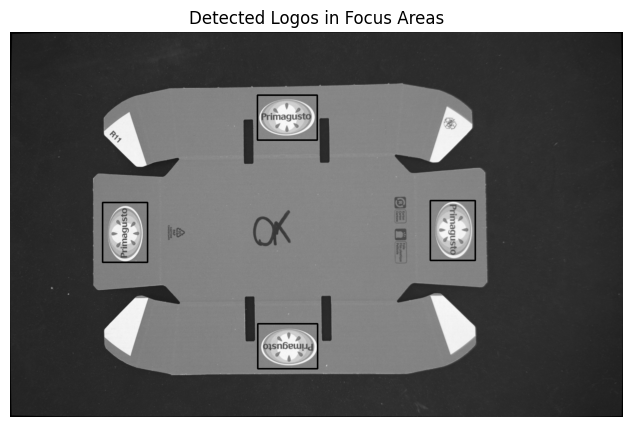

In [61]:
detected_logos_img, logo_detections = detect_logo_in_zones(udst_img, logo, focus_area(udst_img), 0.6)

for zona, info in logo_detections.items():
    print(f"Zona: {zona}")
    print(f"  Logo detectado: {'Sí' if info['found'] else 'No'}")
    print(f"  Similitud máxima: {info['similarity']:.2f}")
    print("-" * 30)
    
plt.figure(figsize=(10, 5))
plt.imshow(detected_logos_img, cmap='gray')
plt.title("Detected Logos in Focus Areas")
plt.axis('off')
plt.show()

(np.float64(-0.5), np.float64(188.5), np.float64(141.5), np.float64(-0.5))

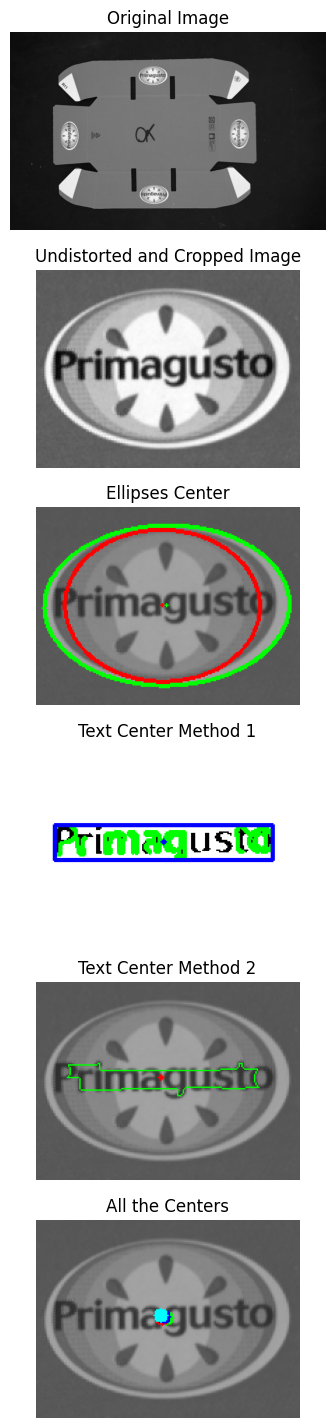

In [62]:
whiteCenter, colorCenter, whiteEllipse, colorEllipse, whiteLengths, colorLengths, img_Result = formCenter(logo_img)
text_Center, img_Text = textCenter(logo_img)
text_C, text_Img = find_word_center(logo_img, colorEllipse)

# We create a color image to place all the centers
img_show = cv.cvtColor(logo_img, cv.COLOR_GRAY2BGR)
# We draw the centers of the ellipses and text in the image
cv.circle(img_show, whiteCenter, 5, (0, 255, 0), -1) # Green for white ellipse center
cv.circle(img_show, colorCenter, 5, (255, 0, 0), -1) # Blue for color ellipse center
cv.circle(img_show, text_Center, 5, (0, 0, 255), -1) # Red for text center
cv.circle(img_show, text_C, 5, (0, 255, 255), -1) # Red for text center

# We show the results
plt.figure(figsize=(20, 18))
plt.subplot(6, 1, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(6, 1, 2)
plt.imshow(logo_img, cmap='gray')
plt.title("Undistorted and Cropped Image")
plt.axis('off')
plt.subplot(6, 1, 3)
plt.imshow(img_Result)
plt.title("Ellipses Center")
plt.axis('off')
plt.subplot(6, 1, 4)
plt.imshow(img_Text)
plt.title("Text Center Method 1")
plt.axis('off')
plt.subplot(6, 1, 5)
plt.imshow(text_Img)
plt.title("Text Center Method 2")
plt.axis('off')
plt.subplot(6, 1, 6)
plt.imshow(img_show)
plt.title("All the Centers")
plt.axis('off')

## Results

In [63]:
d1 = np.linalg.norm((np.array(whiteCenter) - np.array(colorCenter)))
d2 = np.linalg.norm((np.array(colorCenter) - np.array(text_Center)))

d1_mm = d1*res
d2_mm = d2*res

print(f"The missalignment between the ellipses center is: {d1:.2f} pixels which according to the camera resolution corresponds to: {d1_mm:.2f} mm")
print(f"The missalignment between the logo and text center is: {d2:.2f} pixels which according to the camera resolution corresponds to: {d2_mm:.2f} mm")
print(f"Axes Lengths [mm] for the white Ellipse (minor, major): ({whiteLengths[0]*res:.2f}, {whiteLengths[1]*res:.2f})")
print(f"Axes Lengths [mm] for the white Ellipse (minor, major): ({colorLengths[0]*res:.2f}, {colorLengths[1]*res:.2f})")

The missalignment between the ellipses center is: 3.00 pixels which according to the camera resolution corresponds to: 0.66 mm
The missalignment between the logo and text center is: 1.41 pixels which according to the camera resolution corresponds to: 0.31 mm
Axes Lengths [mm] for the white Ellipse (minor, major): (25.14, 38.60)
Axes Lengths [mm] for the white Ellipse (minor, major): (23.82, 30.66)
